In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# method
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from wordcloud import WordCloud

# model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.utils import resample

In [40]:
# matplotlib 한글 폰트 셋업
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
# %config InlineBackend.figure_format = 'retina'
# !apt-get update && apt -qq -y install fonts-nanum 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fm.fontManager.addfont(fontpath)  # 에전의 rebuild 대신 이걸 추가해야 설치한 폰트 추가됨
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)  # Glyph 8722 방지용

### 0. 세계 무역 동향

In [2]:
export_import_sum = pd.read_csv('../DATA/WITS-Import-Export-all.csv')
export_import_sum['Import (US$ Thousand)'] = export_import_sum['Import (US$ Thousand)'] / 1000000
export_import_sum['Import (US$ Thousand)'] = export_import_sum['Import (US$ Thousand)']

export_import_sum['Export (US$ Thousand)'] = export_import_sum['Export (US$ Thousand)'] / 1000000
export_import_sum['Export (US$ Thousand)'] = export_import_sum['Export (US$ Thousand)']

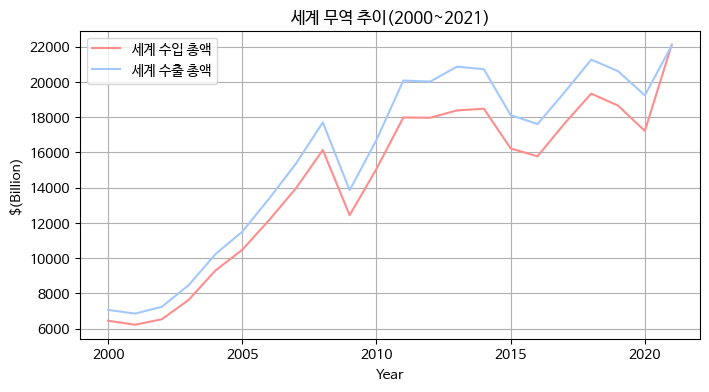

In [4]:
import_sum = export_import_sum['Import (US$ Thousand)']
export_sum = export_import_sum['Export (US$ Thousand)']
Year = export_import_sum['Year']

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Year, import_sum, color='#FF8D8D', label='세계 수입 총액')
ax.plot(Year, export_sum, color='#A3C8FF', label='세계 수출 총액')

x_major_locator = MultipleLocator(5)
ax.xaxis.set_major_locator(x_major_locator)

plt.title('세계 무역 추이(2000~2021)')
plt.grid(True)

plt.xlabel('Year')
plt.ylabel('$(Billion)')
plt.legend()
plt.savefig('./output_3.1/세계 무역 추이.png', dpi=300)
plt.show()

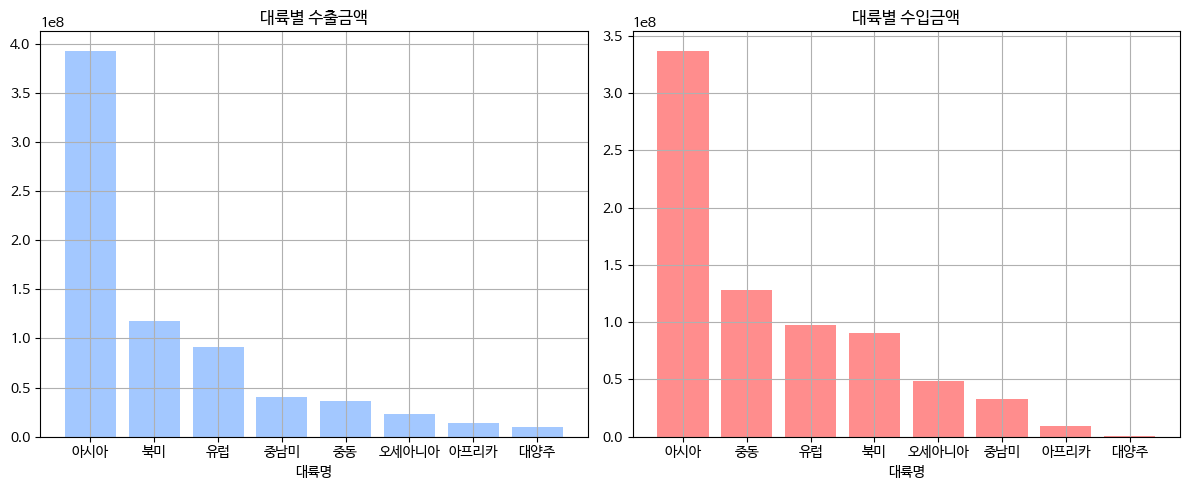

In [5]:
대륙_수출입 = pd.read_csv('../DATA/대륙별 수출입실적_2000~2023.csv',encoding='euc-kr')

# # 달러 단위를 10억 달러로 변경
# df["수출"] = df["수출금액(달러)"] / 1_000_000_000
# df["수입"] = df["수입금액(달러)"] / 1_000_000_000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

x = 대륙_수출입['대륙명']
y_export = 대륙_수출입['수출금액']  # 단위가 '달러'가 아닌듯
y_import = 대륙_수출입['수입금액']

sort_export_idx = y_export.argsort()[::-1]
sort_import_idx = y_import.argsort()[::-1]
x_export_sort = x[sort_export_idx]
x_import_sort = x[sort_import_idx]

y_export_sort = y_export[sort_export_idx]
y_import_sort = y_import[sort_import_idx]

ax1.bar(x_export_sort, y_export_sort,color='#A3C8FF')
ax1.set_xlabel('대륙명')
# ax1.set_ylabel('$(Billion)')  # 단위가 안맞는듯
ax1.set_title('대륙별 수출금액')
ax1.grid(True)

ax2.bar(x_import_sort, y_import_sort, color='#FF8D8D')
ax2.set_xlabel('대륙명')
# ax2.set_ylabel('$(Billion)')
ax2.set_title('대륙별 수입금액')

plt.tight_layout()
ax2.grid(True)
plt.savefig('./output_3.1/대륙별 수출수입.png', dpi=300)
plt.show()

### 1. 한국 수출, 수입, 수지

In [4]:
df = pd.read_csv("../DATA/수출입_All.csv", low_memory=False)

In [5]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3161128 entries, 0 to 3161127
Data columns (total 9 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   무역수지      int64 
 1   수출금액(달러)  int64 
 2   수출중량(KG)  int64 
 3   HS코드      object
 4   수입금액(달러)  int64 
 5   수입중량(KG)  int64 
 6   품목명       object
 7   기간        object
 8   year      int64 
dtypes: int64(6), object(3)
memory usage: 217.1+ MB


,무역수지,수출금액(달러),수출중량(KG),HS코드,수입금액(달러),수입중량(KG),품목명,기간,year
0,-383469,0,0,0101191000,383469,42500,경 주 말,1995.01,1995
1,-237263,0,0,0103100000,237263,13650,번식용,1995.01,1995
2,-496958,0,0,0103910000,496958,42600,중량이 50킬로그램 미만인 것,1995.01,1995
3,-320580,0,0,0105111000,320580,1035,번식용,1995.01,1995
4,-950,0,0,0106001010,950,10,개,1995.01,1995
...,...,...,...,...,...,...,...,...,...
3161123,-106989,59312,303,9706901000,166301,499,도자기류,2023.05,2023
3161124,-566278,0,0,9706902000,566278,5035,악기류,2023.05,2023
3161125,-152056,6679,2,9706903000,158735,556,기타,2023.05,2023
3161126,0,0,0,9999999290,0,681979,-,2023.05,2023


In [8]:
# 총계 제외
df = df.loc[df["HS코드"] != "-", :].copy()

# 달러 단위를 10억 달러로 변경
df["수출"] = df["수출금액(달러)"] / 1_000_000_000
df["수입"] = df["수입금액(달러)"] / 1_000_000_000

df

,무역수지,수출금액(달러),수출중량(KG),HS코드,수입금액(달러),수입중량(KG),품목명,기간,year,수출,수입
0,-383469,0,0,0101191000,383469,42500,경 주 말,1995.01,1995,0.000000,3.834690e-04
1,-237263,0,0,0103100000,237263,13650,번식용,1995.01,1995,0.000000,2.372630e-04
2,-496958,0,0,0103910000,496958,42600,중량이 50킬로그램 미만인 것,1995.01,1995,0.000000,4.969580e-04
3,-320580,0,0,0105111000,320580,1035,번식용,1995.01,1995,0.000000,3.205800e-04
4,-950,0,0,0106001010,950,10,개,1995.01,1995,0.000000,9.500000e-07
...,...,...,...,...,...,...,...,...,...,...,...
3161122,-1746,0,0,9706103000,1746,5,기타,2023.05,2023,0.000000,1.746000e-06
3161123,-106989,59312,303,9706901000,166301,499,도자기류,2023.05,2023,0.000059,1.663010e-04
3161124,-566278,0,0,9706902000,566278,5035,악기류,2023.05,2023,0.000000,5.662780e-04
3161125,-152056,6679,2,9706903000,158735,556,기타,2023.05,2023,0.000007,1.587350e-04


In [9]:
# 연도별 한국 수출, 수입, 수지
yearly = df.groupby("year")[["수출", "수입"]].sum()
yearly["무역수지"] = yearly["수출"] - yearly["수입"]
yearly

,수출,수입,무역수지
year,,,
1995,125.012749,134.912710,-9.899961
1996,130.302047,149.467199,-19.165152
1997,136.100795,144.404210,-8.303415
1998,132.241182,92.886329,39.354853
1999,143.619064,119.276909,24.342155
2000,172.233684,160.204245,12.029439
2001,150.372098,140.970444,9.401654
2002,162.421106,151.957879,10.463227
2003,193.715730,178.495191,15.220539


In [10]:
# 2018 ~ 2023.05 월별로
monthly = df.copy()
monthly["ym"] = monthly["기간"].apply(lambda x: int(x.replace(".", "")))
monthly = monthly.loc[monthly["ym"] >= 201801, :]
monthly = monthly.groupby("기간")[["수출", "수입"]].sum()
monthly.index.name = "month"
monthly["무역수지"] = monthly["수출"] - monthly["수입"]
monthly

,수출,수입,무역수지
month,,,
2018.01,49.189449,45.712374,3.477075
2018.02,44.448811,41.717546,2.731265
2018.03,51.250445,44.851052,6.399394
2018.04,49.814457,43.643729,6.170728
2018.05,50.651749,44.450433,6.201316
...,...,...,...
2023.01,46.151083,58.871168,-12.720085
2023.02,49.896871,55.273408,-5.376536
2023.03,54.686894,59.659369,-4.972474


#### 그래프

- 1995 ~ 2022 연도별 그래프
- 2018.01 ~ 2023.05 월별 그래프

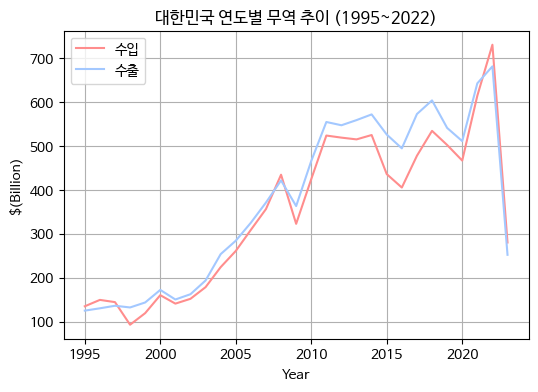

In [11]:
fig, ax = plt.subplots(figsize=(6,4))

yearly['수입'].plot(ax=ax, color='#FF8D8D', label='수입')
yearly['수출'].plot(ax=ax, color='#A3C8FF', label='수출')

ax.set_title('대한민국 연도별 무역 추이 (1995~2022)')
ax.set_xlabel('Year')
ax.set_ylabel('$(Billion)')
ax.legend()
ax.grid(True)
plt.savefig('./output_3.1/한국 수출 및 수입 연도별 추이.jpg')
plt.show()

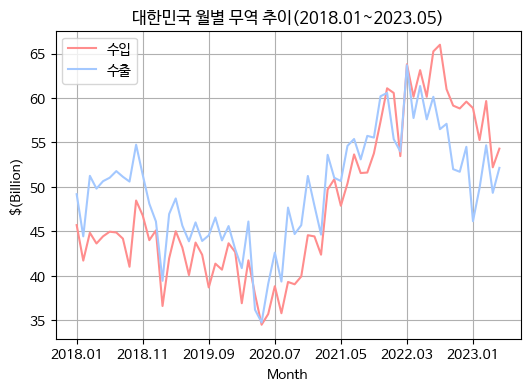

In [12]:
fig, ax = plt.subplots(figsize=(6,4))

monthly['수입'].plot(ax=ax, color='#FF8D8D', label='수입')
monthly['수출'].plot(ax=ax, color='#A3C8FF', label='수출')

ax.set_title('대한민국 월별 무역 추이(2018.01~2023.05)')
ax.set_xlabel('Month')
ax.set_ylabel('$(Billion)')
ax.legend()
ax.grid(True)
plt.savefig('./output_3.1/한국 수출 및 수입 월별 추이.png')

### 2. 주요 무역 국가

In [6]:
export_rank = pd.read_csv('../DATA/수출 지역 순위_2022.csv', encoding='euc-kr')
export_rank['수출금액 (단위:$)'] = export_rank['수출금액 (단위:$)'] / 1000000000
export_rank['수입금액 (단위:$)'] = export_rank['수입금액 (단위:$)'] / 1000000000
export_rank = export_rank.rename(columns = {'수출금액 (단위:$)':'수출금액($(Billion))','수입금액 (단위:$)':'수입금액($(Billion))'})
export_rank[['국가명', '수출금액($(Billion))','수입금액($(Billion))','수출 점유율','수입 점유율']][:12]
export_rank.to_csv('./output_3.1/국가별 수출수입 총액.csv',encoding='euc-kr')

,국가명,수출금액($(Billion)),수입금액($(Billion)),수출 점유율,수입 점유율
0,중국,155.789000,154.576000,22.790062,21.135183
1,미국,109.766000,81.784723,16.057366,11.182406
2,베트남,60.963680,26.724717,8.918233,3.654064
3,일본,30.606278,54.711795,4.477320,7.480731
4,홍콩,27.651186,1.877605,4.045027,0.256725
5,대만,26.198240,28.274594,3.832479,3.865979
6,싱가포르,20.205410,10.347783,2.955802,1.414850
7,인도,18.870071,8.897104,2.760458,1.216499
8,호주,18.753026,44.929397,2.743336,6.143186
9,멕시코,12.654212,8.577372,1.851155,1.172782


In [14]:
export_rank

,수출 지역 순위,국가명,조회기준,수출금액($(Billion)),수입금액($(Billion)),수출 점유율,수입 점유율,품목 HS CODE
0,1,중국,2022,155.789000,154.576000,22.790062,2.113518e+01,전체
1,2,미국,2022,109.766000,81.784723,16.057366,1.118241e+01,전체
2,3,베트남,2022,60.963680,26.724717,8.918233,3.654064e+00,전체
3,4,일본,2022,30.606278,54.711795,4.477320,7.480731e+00,전체
4,5,홍콩,2022,27.651186,1.877605,4.045027,2.567245e-01,전체
...,...,...,...,...,...,...,...,...
241,242,핏케언섬,2022,0.000000,0.000003,0.000000,3.968000e-07,전체
242,243,보빗 군도,2022,0.000000,0.000002,0.000000,3.407000e-07,전체
243,244,허드맥도날드제도,2022,0.000000,0.000027,0.000000,3.742000e-06,전체
244,245,스발바르,2022,0.000000,0.000004,0.000000,5.316000e-07,전체


In [15]:
export_rank_top10 = export_rank[:10]
print('수출액 상위 10개 국가 목록 : ', export_rank_top10['국가명'].unique())

수출액 상위 10개 국가 목록 :  ['중국' '미국' '베트남' '일본' '홍콩' '대만' '싱가포르' '인도' '호주' '멕시코']


In [16]:
import_rank = export_rank.sort_values('수입금액($(Billion))', ascending=False)
import_rank['수입금액($(Billion))'] = import_rank['수입금액($(Billion))'].apply(math.floor)
import_rank['수입 점유율'] = import_rank['수입 점유율'].apply(math.floor)
import_rank

,수출 지역 순위,국가명,조회기준,수출금액($(Billion)),수입금액($(Billion)),수출 점유율,수입 점유율,품목 HS CODE
0,1,중국,2022,155.789000,154,22.790062,21,전체
1,2,미국,2022,109.766000,81,16.057366,11,전체
3,4,일본,2022,30.606278,54,4.477320,7,전체
8,9,호주,2022,18.753026,44,2.743336,6,전체
26,27,사우디아라비아,2022,4.865150,41,0.711711,5,전체
...,...,...,...,...,...,...,...,...
202,203,마요트,2022,0.002054,0,0.000301,0,전체
239,240,바티칸시,2022,0.000000,0,0.000000,0,전체
225,226,"월리스,후투나",2022,0.000089,0,0.000013,0,전체
224,225,신트마르턴(네),2022,0.000093,0,0.000014,0,전체


In [17]:
import_rank_top10 = import_rank[:10].copy()
import_rank_top10["국가명"] = import_rank_top10["국가명"].replace({"사우디아라비아": "사우디"})
print('수입액 상위 10개 국가 목록 : ', import_rank_top10['국가명'].unique())

수입액 상위 10개 국가 목록 :  ['중국' '미국' '일본' '호주' '사우디' '대만' '베트남' '독일' '카타르' '인도네시아']


#### 그래프

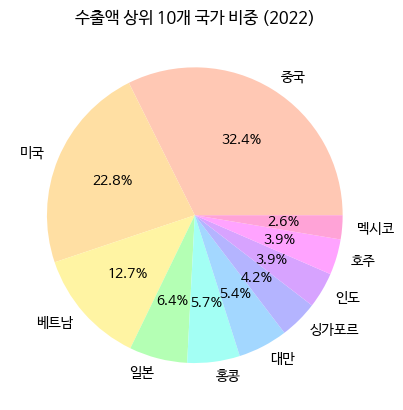

In [18]:
pastel_colors = ['#FFC8B4', '#FFDFA3', '#FFF4A3', '#B4FFB4', '#A3FFF4', '#A3D7FF', '#B4B4FF', '#D7A3FF', '#FFA3FF', '#FFA3D7']
plt.pie(export_rank_top10['수출금액($(Billion))'], autopct='%.1f%%', labels=export_rank_top10['국가명'], colors=pastel_colors)
plt.title('수출액 상위 10개 국가 비중 (2022)')
plt.savefig('./output_3.1/수출액 상위 10개 국가의 수출액 비중.png', dpi=300)
plt.show()

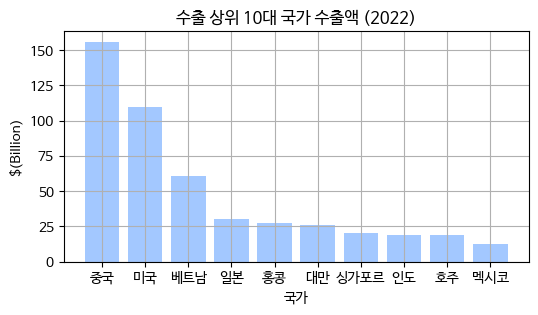

In [19]:
plt.figure(figsize=(6,3))
x = export_rank_top10['국가명']
y = export_rank_top10['수출금액($(Billion))']
plt.bar(x,y,color='#A3C8FF')
plt.title("수출 상위 10대 국가 수출액 (2022)")
plt.grid(True)
plt.xlabel('국가')
plt.ylabel('$(Billion)')
plt.savefig('./output_3.1/우리나라 수출금액 상위 10대 국가의 수출금액.png', dpi=300)
plt.show()

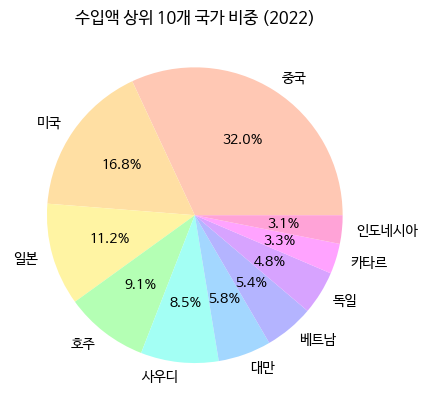

In [20]:
pastel_colors = ['#FFC8B4', '#FFDFA3', '#FFF4A3', '#B4FFB4', '#A3FFF4', '#A3D7FF', '#B4B4FF', '#D7A3FF', '#FFA3FF', '#FFA3D7']
plt.pie(import_rank_top10['수입금액($(Billion))'], autopct='%.1f%%', labels=import_rank_top10['국가명'], colors=pastel_colors)
plt.title('수입액 상위 10개 국가 비중 (2022)')
plt.savefig('./output_3.1/수입액 상위 10개 국가의 수입액 비중.png', dpi=300)
plt.show()

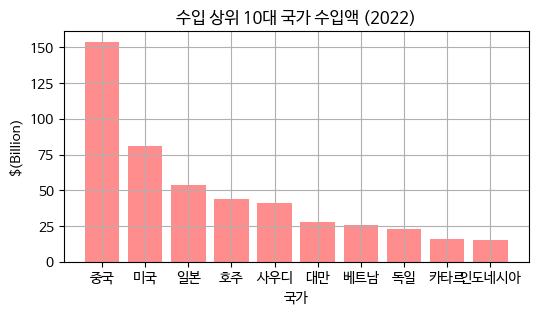

In [21]:
plt.figure(figsize=(6,3))
x = import_rank_top10['국가명']
y = import_rank_top10['수입금액($(Billion))']
plt.bar(x,y,color='#FF8D8D')
plt.title("수입 상위 10대 국가 수입액 (2022)")
plt.grid(True)
plt.xlabel('국가')
plt.ylabel('$(Billion)')
plt.savefig('./output_3.1/우리나라 수입금액 상위 10대 국가의 수입금액.png', dpi=300)
plt.show()

#### 그래프 (2022년 기준 수출 상위 10개 국가)

In [37]:
countries = ['CN', 'US', 'VN', 'JP', 'HK', 'TW', 'SG', 'IN', 'AU', 'MX']
names = ["중국", "미국", "베트남", "일본", "홍콩", "대만", "싱가포르", "인도", "호주", "멕시코"]

  0%|          | 0/10 [00:00<?, ?it/s]

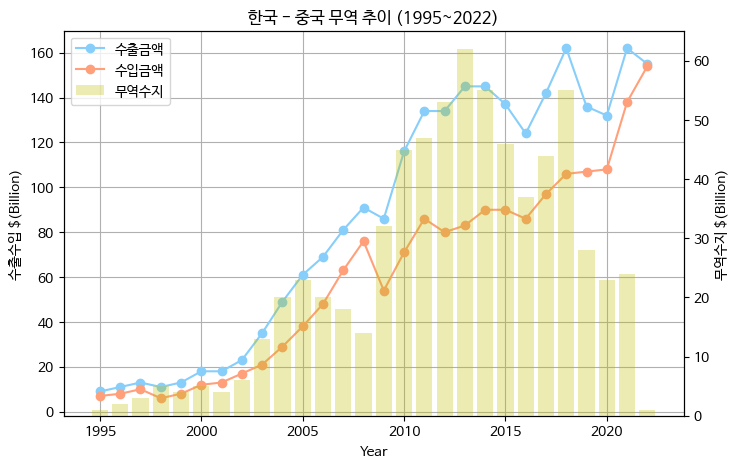

 10%|█         | 1/10 [00:07<01:04,  7.13s/it]

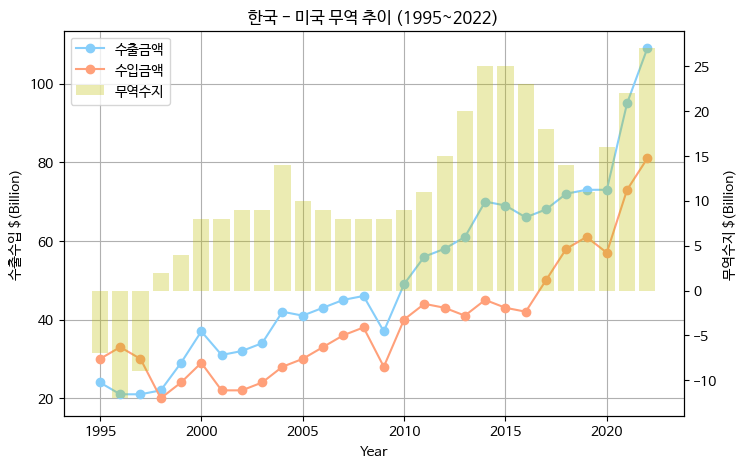

 20%|██        | 2/10 [00:13<00:53,  6.74s/it]

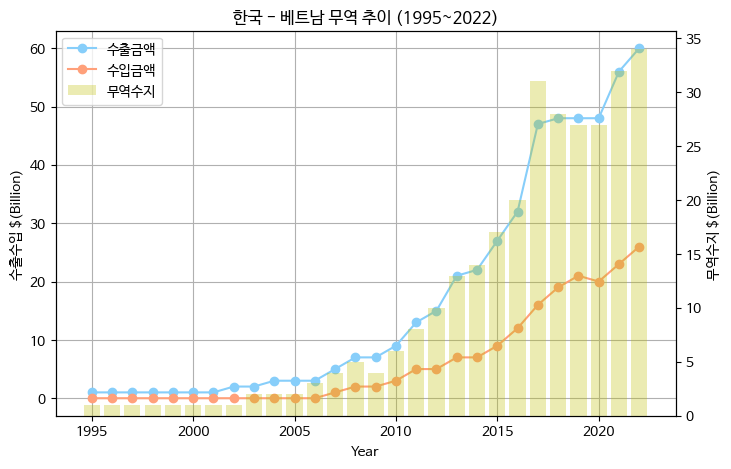

 30%|███       | 3/10 [00:17<00:37,  5.39s/it]

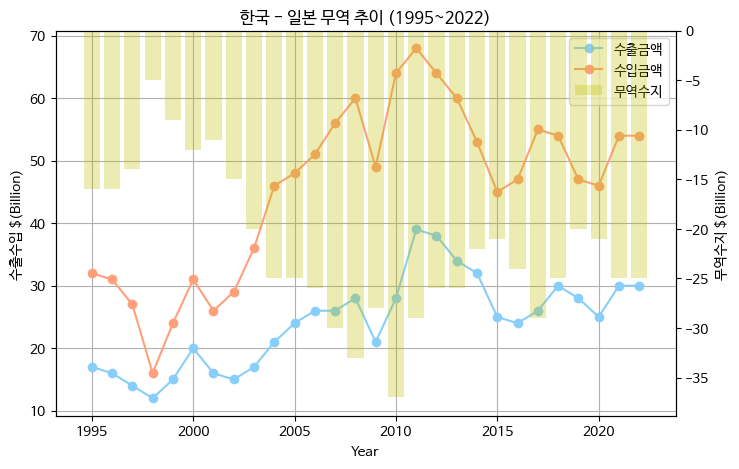

 40%|████      | 4/10 [00:23<00:34,  5.73s/it]

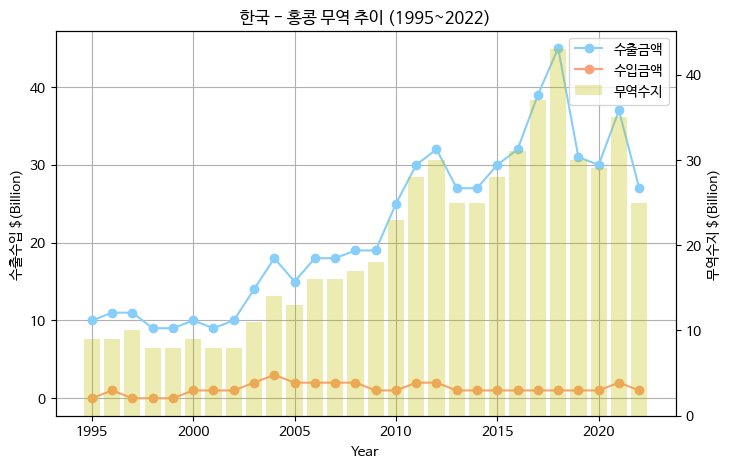

 50%|█████     | 5/10 [00:26<00:23,  4.74s/it]

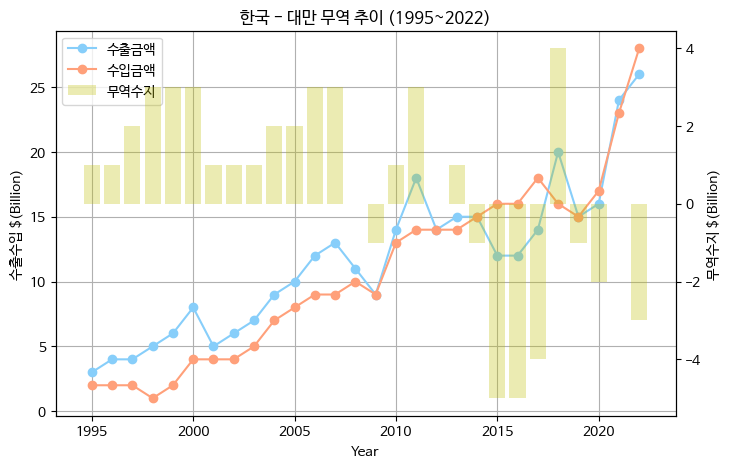

 60%|██████    | 6/10 [00:30<00:17,  4.32s/it]

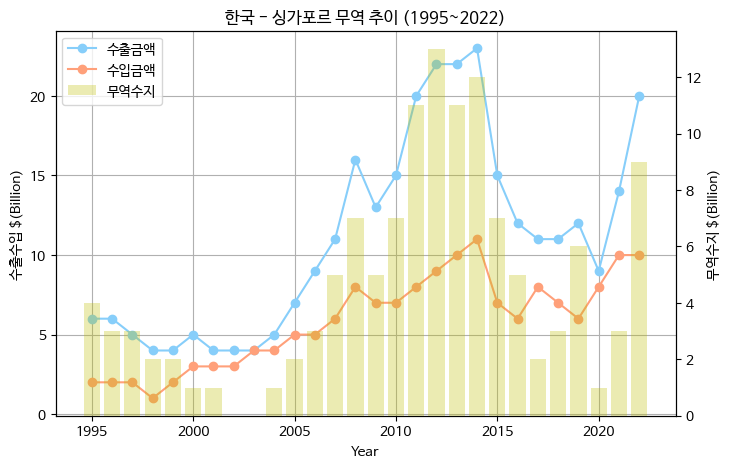

 70%|███████   | 7/10 [00:32<00:11,  3.84s/it]

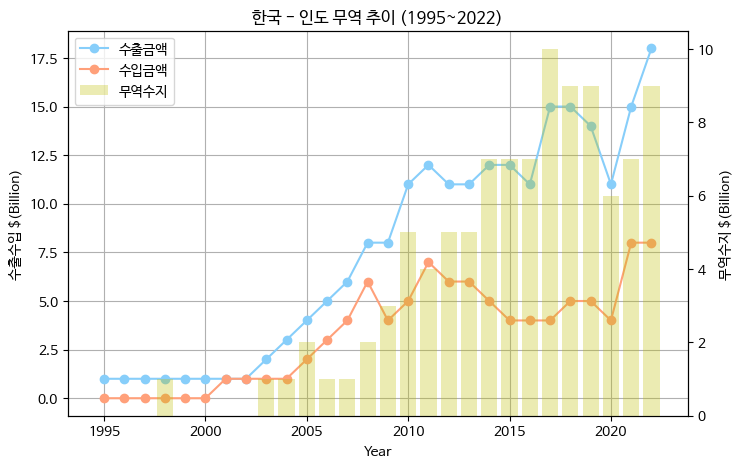

 80%|████████  | 8/10 [00:35<00:06,  3.42s/it]

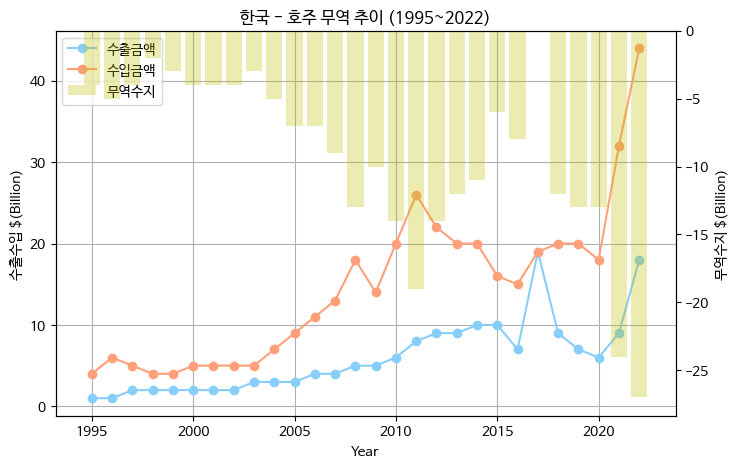

 90%|█████████ | 9/10 [00:37<00:03,  3.08s/it]

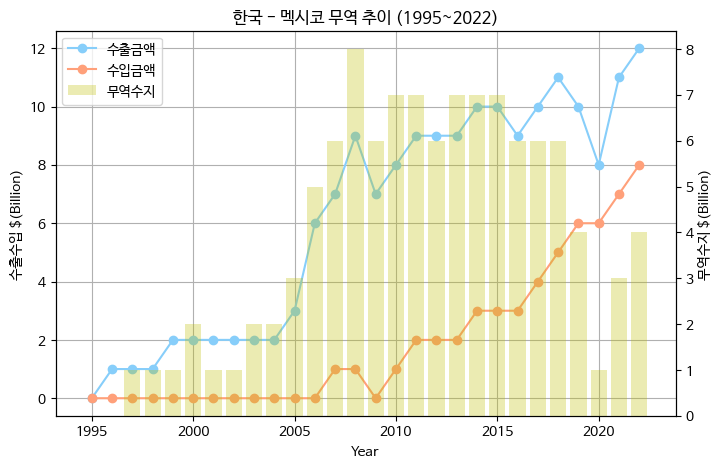

100%|██████████| 10/10 [00:39<00:00,  3.96s/it]


In [38]:
for c, n in tqdm(list(zip(countries, names))):
    export_import = pd.read_csv(f'../DATA/수출입_국가별({c}).csv',low_memory=False)
    export_import = export_import[export_import['HS코드'] != '-']
    export_import['HS4'] = export_import['HS코드'].str[:-6]

    export_import['수출금액($(billion))'] = export_import['수출금액(달러)'] / 1_000_000_000
    export_import['수입금액($(billion))'] = export_import['수입금액(달러)'] / 1_000_000_000
    export_import['무역수지($(billion))'] = export_import['무역수지'] / 1_000_000_000

    export_import_year = export_import.groupby('year')[['수출금액($(billion))','수입금액($(billion))','무역수지($(billion))']].sum()
    export_import_year = export_import_year.reset_index()
    export_import_year['수출금액($(billion))'] = export_import_year['수출금액($(billion))'].apply(math.floor)
    export_import_year['수입금액($(billion))'] = export_import_year['수입금액($(billion))'].apply(math.floor)
    export_import_year['무역수지($(billion))'] = export_import_year['무역수지($(billion))'].apply(math.floor)

    # export_import_year.head()
    
    
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # 수출금액과 수입금액 선 그래프
    ax1.plot(export_import_year.groupby('year')['수출금액($(billion))'].sum(), marker='o', linestyle='-', color='#87CEFA', label='수출금액')
    ax1.plot(export_import_year.groupby('year')['수입금액($(billion))'].sum(), marker='o', linestyle='-', color='#FFA07A', label='수입금액')
    ax1.set_ylabel('수출수입 $(Billion)')
    ax1.set_xlabel('Year')

    # 무역수지 막대 그래프
    ax2 = ax1.twinx()
    ax2.bar(export_import_year.groupby('year').groups.keys(), export_import_year.groupby('year')['무역수지($(billion))'].sum(), color='y', alpha=0.3, label='무역수지')
    ax2.set_ylabel('무역수지 $(Billion)')

    # 범례 표시
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='best')
    ax1.grid(True)

    plt.title(f'한국 - {n} 무역 추이 (1995~2022)')
    plt.savefig(f'./output_3.1/대외무역_추이_{n}({c}).jpg')
    plt.show()

### 3. 한국 주요 무역 품목

### 3.1 수출품목

In [7]:
df = pd.read_csv("../수출입_All.csv", low_memory=False)
df = df.loc[df["HS코드"] != "-", :]

In [8]:
# HS 코드 처리
df["HS2"] = df["HS코드"].str[:2]
df["HS4"] = df["HS코드"].str[:4]
df

,무역수지,수출금액(달러),수출중량(KG),HS코드,수입금액(달러),수입중량(KG),품목명,기간,year,HS2,HS4
0,-383469,0,0,0101191000,383469,42500,경 주 말,1995.01,1995,01,0101
1,-237263,0,0,0103100000,237263,13650,번식용,1995.01,1995,01,0103
2,-496958,0,0,0103910000,496958,42600,중량이 50킬로그램 미만인 것,1995.01,1995,01,0103
3,-320580,0,0,0105111000,320580,1035,번식용,1995.01,1995,01,0105
4,-950,0,0,0106001010,950,10,개,1995.01,1995,01,0106
...,...,...,...,...,...,...,...,...,...,...,...
3161122,-1746,0,0,9706103000,1746,5,기타,2023.05,2023,97,9706
3161123,-106989,59312,303,9706901000,166301,499,도자기류,2023.05,2023,97,9706
3161124,-566278,0,0,9706902000,566278,5035,악기류,2023.05,2023,97,9706
3161125,-152056,6679,2,9706903000,158735,556,기타,2023.05,2023,97,9706


In [36]:
HS4_replace_dict = {'2601':'철광', 
'2701':'연탄,조개탄', '2709':'석유,역청유', '2710':'석유,역청유', '2711':'석유가스, 탄화수소',
'2841':'산화금속산염, 과산화금속산염',
'2902':'환식탄화수소',
'2601':'철광',
'7106' : '은',
'7208' : '비도금 강판(포일)', '7210' : '도금 강판(포일)',
'7308' : '철강 구조물',
'8471':'비전기식 공업용 노, 오븐', '8473':'보일러 부속품', '8486' : '반도체, 전자직접회로',
'8507':'축전지', '8517':'전화기', '8523':'디스크,스마트 카드', '8529':'전자기기 부속품', 
'8524' : '평판디스플레이 모듈', '8542':'전자집적회로','8534':'인쇄회로',
'8703':'승용차', '8708':'차량 부속품',
'8901':'순항선,유람선,화물선', '8905':'특수 선박',
'9013':'레이저기기'}

In [11]:
# 2022년 기준
top_n = 10

temp = df.loc[df["year"] == 2022, :].copy()
hs2_top10_2022 = temp.groupby("HS2")["수출금액(달러)"].sum().sort_values(ascending=False).iloc[:top_n]

temp = df.loc[df["year"] == 2022, :].copy()
hs4_top10_2022 = temp.groupby("HS4")["수출금액(달러)"].sum().sort_values(ascending=False).iloc[:top_n]

top10_2022 = pd.DataFrame(index=range(1, 10+1))
top10_2022.index.name = "#"

# 수출금액은 10억달러로
top10_2022["HS2"] = hs2_top10_2022.index
top10_2022["HS2_exp"] = hs2_top10_2022.values / 1_000_000_000
top10_2022["HS4"] = hs4_top10_2022.index
top10_2022["HS4_exp"] = hs4_top10_2022.values / 1_000_000_000

top10_2022

,HS2,HS2_exp,HS4,HS4_exp
#,,,,
1,85,210.434594,8542,112.847160
2,87,75.474475,2710,61.560257
3,84,73.033189,8703,51.680334
4,27,64.751329,8708,19.921904
5,39,41.158081,8524,19.449061
6,72,28.108456,8901,15.259262
7,29,24.304090,8523,14.294772
8,90,18.208567,8473,12.540939
9,89,17.137707,2841,11.268256


In [12]:
# 1995~2022 평균
top_n = 10

length = len(range(1995, 2022 + 1))  # 연평균 계산을 위한 연도 수(28년)

temp = df.loc[df["year"] <= 2022, :].copy()
hs2_top10 = temp.groupby("HS2")["수출금액(달러)"].sum().sort_values(ascending=False).iloc[:top_n] / length

temp = df.copy()
hs4_top10 = temp.groupby("HS4")["수출금액(달러)"].sum().sort_values(ascending=False).iloc[:top_n] / length

top10 = pd.DataFrame(index=range(1, 10+1))
top10.index.name = "#"

# 수출금액은 10억달러로
top10["HS2"] = hs2_top10.index
top10["HS2_exp"] = hs2_top10.values / 1_000_000_000
top10["HS4"] = hs4_top10.index
top10["HS4_exp"] = hs4_top10.values / 1_000_000_000

top10

,HS2,HS2_exp,HS4,HS4_exp
#,,,,
1,85,101.830220,8542,43.707224
2,84,45.717083,8703,29.668065
3,87,43.795390,2710,26.029576
4,27,26.929438,8901,18.569533
5,89,23.609981,8517,13.622037
6,39,20.336907,8708,12.498091
7,90,18.573188,9013,11.563187
8,72,15.909924,8473,7.018814
9,29,13.963011,8529,6.178851


In [13]:
HS2_replace_dict = {'85': '전기기기·TV·VTR', '87': '일반차량', '84': '보일러·기계류',
                    '27': '광물성연료,에너지', '39': '플라스틱과그제품', '72': '철강',
                    '29': '유기화합물', '90': '광학·의료·측정·검사·정밀기기', '89': '선박',
                    '28': '무기화합물'}

In [14]:
top10_2022['HS2_copy'] = top10_2022['HS2'].copy()
top10_2022['HS4_copy'] = top10_2022['HS4'].copy()

top10_2022['품목명+HS2'] = top10_2022['HS2_copy'].replace(HS2_replace_dict)
top10_2022['품목명+HS4'] = top10_2022['HS4_copy'].replace(HS4_replace_dict)

top10_2022['품목명(HS2)'] = top10_2022['품목명+HS2']+'('+top10_2022['HS2']+')'
top10_2022['품목명(HS4)'] = top10_2022['품목명+HS4']+'('+top10_2022['HS4']+')'

columns_drop = ['HS2_copy','HS4_copy','품목명+HS2','품목명+HS4']
top10_2022.drop(columns_drop, axis=1, inplace=True)
top10_2022.to_csv('./output_3.1/top10_2022.csv',encoding='euc-kr')
top10_2022

,HS2,HS2_exp,HS4,HS4_exp,품목명(HS2),품목명(HS4)
#,,,,,,
1,85,210.434594,8542,112.847160,전기기기·TV·VTR(85),전자집적회로(8542)
2,87,75.474475,2710,61.560257,일반차량(87),"석유,역청유(2710)"
3,84,73.033189,8703,51.680334,보일러·기계류(84),승용차(8703)
4,27,64.751329,8708,19.921904,"광물성연료,에너지(27)",차량 부속품(8708)
5,39,41.158081,8524,19.449061,플라스틱과그제품(39),평판디스플레이 모듈(8524)
6,72,28.108456,8901,15.259262,철강(72),"순항선,유람선,화물선(8901)"
7,29,24.304090,8523,14.294772,유기화합물(29),"디스크,스마트 카드(8523)"
8,90,18.208567,8473,12.540939,광학·의료·측정·검사·정밀기기(90),보일러 부속품(8473)
9,89,17.137707,2841,11.268256,선박(89),"산화금속산염, 과산화금속산염(2841)"


In [15]:
HS2_replace_dict = {'85': '전기기기·TV·VTR', '84': '보일러·기계류', '87': '일반차량',
                    '27': '광물성연료,에너지', '89': '선박', '39': '플라스틱과그제품', 
                    '90': '광학·의료·측정·검사·정밀기기', '72': '철강', '29': '유기화합물', 
                    '73': '철강제품'}

In [16]:
top10['HS2_copy'] = top10['HS2'].copy()
top10['HS4_copy'] = top10['HS4'].copy()

top10['품목명+HS2'] = top10['HS2_copy'].replace(HS2_replace_dict)
top10['품목명+HS4'] = top10['HS4_copy'].replace(HS4_replace_dict)

top10['품목명(HS2)'] = top10['품목명+HS2']+'('+top10['HS2']+')'
top10['품목명(HS4)'] = top10['품목명+HS4']+'('+top10['HS4']+')'

columns_drop = ['HS2_copy','HS4_copy','품목명+HS2','품목명+HS4']
top10.drop(columns_drop, axis=1, inplace=True)
top10.to_csv('./output_3.1/top10.csv',encoding='euc-kr')
top10

,HS2,HS2_exp,HS4,HS4_exp,품목명(HS2),품목명(HS4)
#,,,,,,
1,85,101.830220,8542,43.707224,전기기기·TV·VTR(85),전자집적회로(8542)
2,84,45.717083,8703,29.668065,보일러·기계류(84),승용차(8703)
3,87,43.795390,2710,26.029576,일반차량(87),"석유,역청유(2710)"
4,27,26.929438,8901,18.569533,"광물성연료,에너지(27)","순항선,유람선,화물선(8901)"
5,89,23.609981,8517,13.622037,선박(89),전화기(8517)
6,39,20.336907,8708,12.498091,플라스틱과그제품(39),차량 부속품(8708)
7,90,18.573188,9013,11.563187,광학·의료·측정·검사·정밀기기(90),레이저기기(9013)
8,72,15.909924,8473,7.018814,철강(72),보일러 부속품(8473)
9,29,13.963011,8529,6.178851,유기화합물(29),전자기기 부속품(8529)


#### 그래프

- hs2, hs4를 코드에 더해 명칭을 추가해서 그래프 그릴 때 사용하기
- `명칭(hs코드)` 형태 (코드를 꼭 남겨놓기)

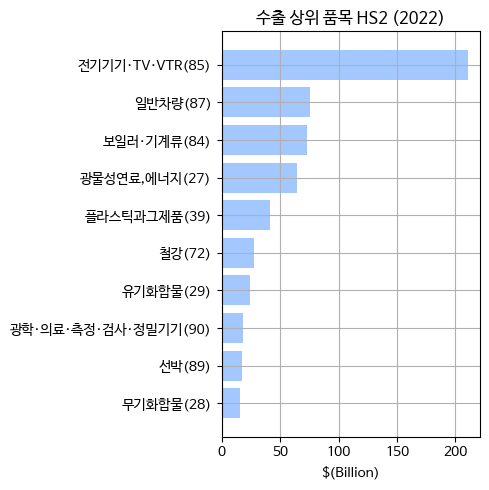

In [17]:
x = top10_2022['품목명(HS2)']
y = top10_2022['HS2_exp']
plt.figure(figsize=(5, 5))
plt.barh(x[::-1],y[::-1],color='#A3C8FF')
plt.title('수출 상위 품목 HS2 (2022)')
plt.grid(True)
plt.xlabel('$(Billion)')
plt.tight_layout()
plt.savefig('./output_3.1/수출 상위 품목HS2 (2022).png', dpi=300)
plt.show()

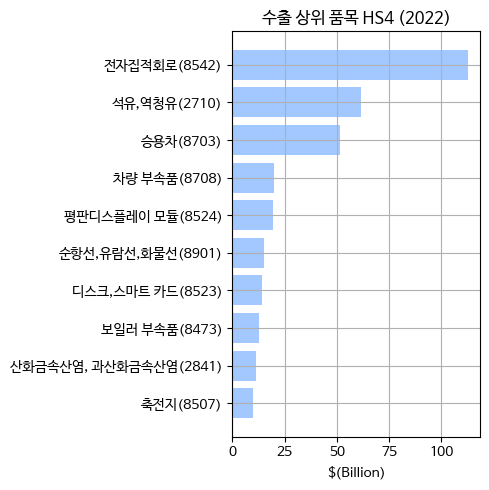

In [18]:
x = top10_2022['품목명(HS4)']
y = top10_2022['HS4_exp']
# plt.barh(x[::-1],y[::-1],color='lightgray', alpha=0.9)
plt.figure(figsize=(5, 5))
plt.barh(x[::-1],y[::-1],color='#A3C8FF')
plt.title('수출 상위 품목 HS4 (2022)')
plt.grid(True)
plt.xlabel('$(Billion)')
plt.tight_layout()
plt.savefig('./output_3.1/수출 상위 품목HS4 (2022).png', dpi=300)
plt.show()

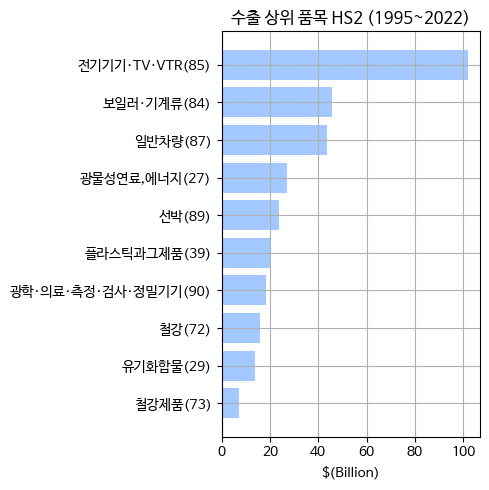

In [19]:
x = top10['품목명(HS2)']
y = top10['HS2_exp']
plt.figure(figsize=(5, 5))
plt.barh(x[::-1],y[::-1],color='#A3C8FF')
plt.title('수출 상위 품목 HS2 (1995~2022)')
plt.grid(True)
plt.xlabel('$(Billion)')
plt.tight_layout()
plt.savefig('./output_3.1/수출 상위 품목HS2 (1995~2022).png', dpi=300)
plt.show()

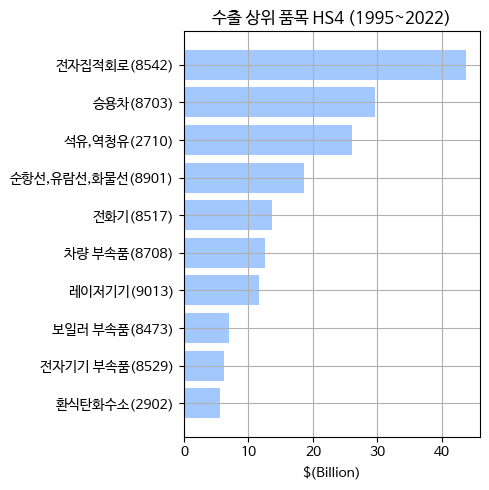

In [20]:
x = top10['품목명(HS4)']
y = top10['HS4_exp']
plt.figure(figsize=(5, 5))
# plt.barh(x[::-1],y[::-1],color='lightgray', alpha=0.9)
plt.barh(x[::-1],y[::-1],color='#A3C8FF')
plt.title('수출 상위 품목 HS4 (1995~2022)')
plt.grid(True)
plt.xlabel('$(Billion)')
plt.tight_layout()
plt.savefig('./output_3.1/수출 상위 품목HS4 (1995~2022).png', dpi=300)
plt.show()

### 3.2 수입품목

In [21]:
df = pd.read_csv("../수출입_All.csv", low_memory=False)
df = df.loc[df["HS코드"] != "-", :]

In [22]:
# HS 코드 처리
df["HS2"] = df["HS코드"].str[:2]
df["HS4"] = df["HS코드"].str[:4]
df

,무역수지,수출금액(달러),수출중량(KG),HS코드,수입금액(달러),수입중량(KG),품목명,기간,year,HS2,HS4
0,-383469,0,0,0101191000,383469,42500,경 주 말,1995.01,1995,01,0101
1,-237263,0,0,0103100000,237263,13650,번식용,1995.01,1995,01,0103
2,-496958,0,0,0103910000,496958,42600,중량이 50킬로그램 미만인 것,1995.01,1995,01,0103
3,-320580,0,0,0105111000,320580,1035,번식용,1995.01,1995,01,0105
4,-950,0,0,0106001010,950,10,개,1995.01,1995,01,0106
...,...,...,...,...,...,...,...,...,...,...,...
3161122,-1746,0,0,9706103000,1746,5,기타,2023.05,2023,97,9706
3161123,-106989,59312,303,9706901000,166301,499,도자기류,2023.05,2023,97,9706
3161124,-566278,0,0,9706902000,566278,5035,악기류,2023.05,2023,97,9706
3161125,-152056,6679,2,9706903000,158735,556,기타,2023.05,2023,97,9706


In [23]:
# 2022년 기준
top_n = 10

temp = df.loc[df["year"] == 2022, :].copy()
hs2_top10_2022 = temp.groupby("HS2")["수입금액(달러)"].sum().sort_values(ascending=False).iloc[:top_n]

temp = df.loc[df["year"] == 2022, :].copy()
hs4_top10_2022 = temp.groupby("HS4")["수입금액(달러)"].sum().sort_values(ascending=False).iloc[:top_n]

top10_2022 = pd.DataFrame(index=range(1, 10+1))
top10_2022.index.name = "#"

# 수출금액은 10억달러로
top10_2022["HS2"] = hs2_top10_2022.index
top10_2022["HS2_imp"] = hs2_top10_2022.values / 1_000_000_000
top10_2022["HS4"] = hs4_top10_2022.index
top10_2022["HS4_imp"] = hs4_top10_2022.values / 1_000_000_000

top10_2022

,HS2,HS2_imp,HS4,HS4_imp
#,,,,
1,27,218.678955,2709,105.963516
2,85,131.761151,8542,62.400258
3,84,68.423577,2711,56.749275
4,90,22.677486,2701,28.154283
5,26,21.847940,2710,26.325116
6,87,21.652065,8486,20.142344
7,28,19.996406,8703,14.048939
8,72,18.943803,8517,12.389075
9,29,16.104288,8471,9.500684


In [24]:
# 1995~2022 평균
top_n = 10

length = len(range(1995, 2022 + 1))  # 연평균 계산을 위한 연도 수(28년)

temp = df.loc[df["year"] <= 2022, :].copy()
hs2_top10 = temp.groupby("HS2")["수입금액(달러)"].sum().sort_values(ascending=False).iloc[:top_n] / length

temp = df.copy()
hs4_top10 = temp.groupby("HS4")["수입금액(달러)"].sum().sort_values(ascending=False).iloc[:top_n] / length

top10 = pd.DataFrame(index=range(1, 10+1))
top10.index.name = "#"

# 수출금액은 10억달러로
top10["HS2"] = hs2_top10.index
top10["HS2_imp"] = hs2_top10.values / 1_000_000_000
top10["HS4"] = hs4_top10.index
top10["HS4_imp"] = hs4_top10.values / 1_000_000_000

top10

,HS2,HS2_imp,HS4,HS4_imp
#,,,,
1,27,94.321644,2709,54.236555
2,85,59.539194,8542,25.830576
3,84,38.105045,2711,18.634398
4,72,15.140949,2710,13.439118
5,90,13.364846,2701,9.368638
6,26,10.031499,8486,6.896951
7,29,9.787501,8517,5.993110
8,87,8.553198,8703,4.836170
9,39,7.400594,8471,4.744367


In [25]:
HS2_replace_dict = {'27':'광물성연료,에너지','85':'전기기기·TV·VTR','84':'보일러·기계류',
                    '90':'광학·의료·측정·검사·정밀기기','26':'광,슬랙,회','87':'일반차량',
                    '28': '무기화합물','72': '철강','29': '유기화합물','39':'플라스틱과그제품'}

In [26]:
top10_2022['HS2_copy'] = top10_2022['HS2'].copy()
top10_2022['HS4_copy'] = top10_2022['HS4'].copy()

top10_2022['품목명+HS2'] = top10_2022['HS2_copy'].replace(HS2_replace_dict)
top10_2022['품목명+HS4'] = top10_2022['HS4_copy'].replace(HS4_replace_dict)

top10_2022['품목명(HS2)'] = top10_2022['품목명+HS2']+'('+top10_2022['HS2']+')'
top10_2022['품목명(HS4)'] = top10_2022['품목명+HS4']+'('+top10_2022['HS4']+')'

columns_drop = ['HS2_copy','HS4_copy','품목명+HS2','품목명+HS4']
top10_2022.drop(columns_drop, axis=1, inplace=True)
top10_2022.to_csv('./output_3.1/top10_2022.csv',encoding='euc-kr')
top10_2022

,HS2,HS2_imp,HS4,HS4_imp,품목명(HS2),품목명(HS4)
#,,,,,,
1,27,218.678955,2709,105.963516,"광물성연료,에너지(27)","석유,역청유(2709)"
2,85,131.761151,8542,62.400258,전기기기·TV·VTR(85),전자집적회로(8542)
3,84,68.423577,2711,56.749275,보일러·기계류(84),"석유가스, 탄화수소(2711)"
4,90,22.677486,2701,28.154283,광학·의료·측정·검사·정밀기기(90),"연탄,조개탄(2701)"
5,26,21.847940,2710,26.325116,"광,슬랙,회(26)","석유,역청유(2710)"
6,87,21.652065,8486,20.142344,일반차량(87),"반도체, 전자직접회로(8486)"
7,28,19.996406,8703,14.048939,무기화합물(28),승용차(8703)
8,72,18.943803,8517,12.389075,철강(72),전화기(8517)
9,29,16.104288,8471,9.500684,유기화합물(29),"비전기식 공업용 노, 오븐(8471)"


In [27]:
HS2_replace_dict = {'27':'광물성연료,에너지','85':'전기기기·TV·VTR','84':'보일러·기계류',
                    '72': '철강','90':'광학·의료·측정·검사·정밀기기','26':'광,슬랙,회',
                    '29': '유기화합물','87':'일반차량','39':'플라스틱과그제품',
                    '38': '각종화학공업생산품'}

In [28]:
top10['HS2_copy'] = top10['HS2'].copy()
top10['HS4_copy'] = top10['HS4'].copy()

top10['품목명+HS2'] = top10['HS2_copy'].replace(HS2_replace_dict)
top10['품목명+HS4'] = top10['HS4_copy'].replace(HS4_replace_dict)

top10['품목명(HS2)'] = top10['품목명+HS2']+'('+top10['HS2']+')'
top10['품목명(HS4)'] = top10['품목명+HS4']+'('+top10['HS4']+')'

columns_drop = ['HS2_copy','HS4_copy','품목명+HS2','품목명+HS4']
top10.drop(columns_drop, axis=1, inplace=True)
top10.to_csv('./output_3.1/top10.csv',encoding='euc-kr')
top10

,HS2,HS2_imp,HS4,HS4_imp,품목명(HS2),품목명(HS4)
#,,,,,,
1,27,94.321644,2709,54.236555,"광물성연료,에너지(27)","석유,역청유(2709)"
2,85,59.539194,8542,25.830576,전기기기·TV·VTR(85),전자집적회로(8542)
3,84,38.105045,2711,18.634398,보일러·기계류(84),"석유가스, 탄화수소(2711)"
4,72,15.140949,2710,13.439118,철강(72),"석유,역청유(2710)"
5,90,13.364846,2701,9.368638,광학·의료·측정·검사·정밀기기(90),"연탄,조개탄(2701)"
6,26,10.031499,8486,6.896951,"광,슬랙,회(26)","반도체, 전자직접회로(8486)"
7,29,9.787501,8517,5.993110,유기화합물(29),전화기(8517)
8,87,8.553198,8703,4.836170,일반차량(87),승용차(8703)
9,39,7.400594,8471,4.744367,플라스틱과그제품(39),"비전기식 공업용 노, 오븐(8471)"


#### 그래프

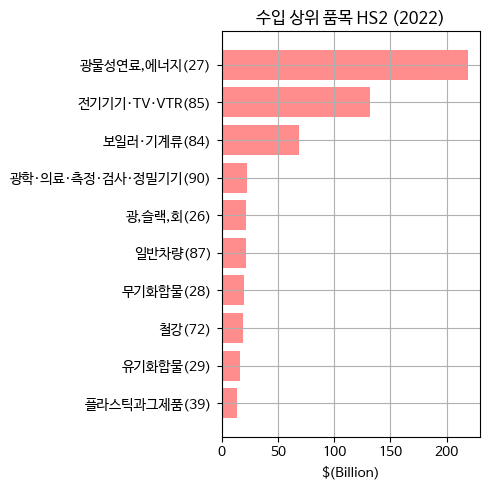

In [29]:
x = top10_2022['품목명(HS2)']
y = top10_2022['HS2_imp']
plt.figure(figsize=(5, 5))
plt.barh(x[::-1],y[::-1],color='#FF8D8D')
plt.title('수입 상위 품목 HS2 (2022)')
plt.grid(True)
plt.xlabel('$(Billion)')
plt.tight_layout()
plt.savefig('./output_3.1/수입 상위 품목HS2 (2022).png', dpi=300)
plt.show()

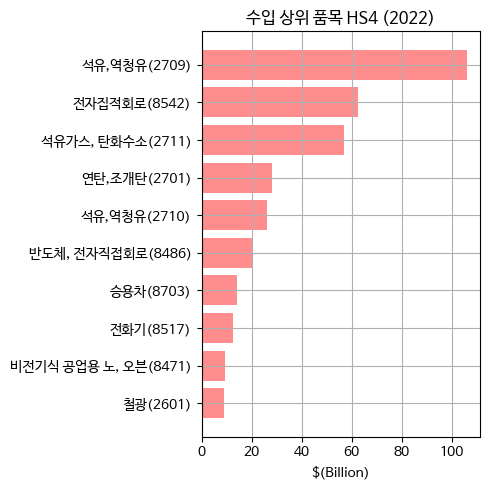

In [30]:
x = top10_2022['품목명(HS4)']
y = top10_2022['HS4_imp']
plt.figure(figsize=(5, 5))
plt.barh(x[::-1],y[::-1],color='#FF8D8D')
plt.title('수입 상위 품목 HS4 (2022)')
plt.grid(True)
plt.xlabel('$(Billion)')
plt.tight_layout()
plt.savefig('./output_3.1/수입 상위 품목HS4 (2022).png', dpi=300)
plt.show()

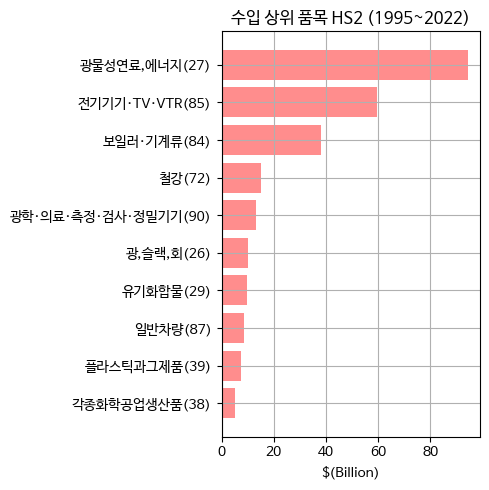

In [31]:
x = top10['품목명(HS2)']
y = top10['HS2_imp']
plt.figure(figsize=(5, 5))
plt.barh(x[::-1],y[::-1],color='#FF8D8D')
plt.title('수입 상위 품목 HS2 (1995~2022)')
plt.grid(True)
plt.xlabel('$(Billion)')
plt.tight_layout()
plt.savefig('./output_3.1/수입 상위 품목HS2 (1995~2022).png', dpi=300)
plt.show()

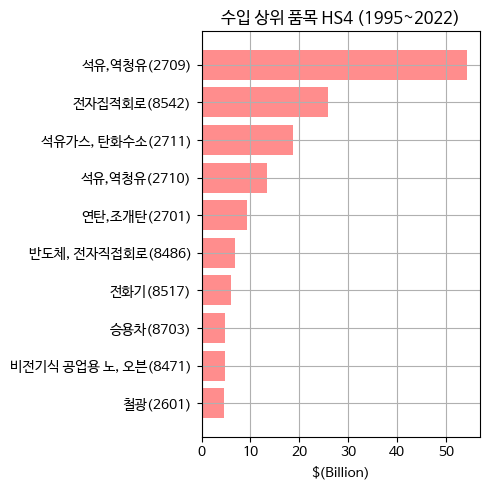

In [32]:
x = top10['품목명(HS4)']
y = top10['HS4_imp']
plt.figure(figsize=(5, 5))
plt.barh(x[::-1],y[::-1],color='#FF8D8D')
plt.title('수입 상위 품목 HS4 (1995~2022)')
plt.grid(True)
plt.xlabel('$(Billion)')
plt.tight_layout()
plt.savefig('./output_3.1/수입 상위 품목HS4 (1995~2022).png', dpi=300)
plt.show()

### 4. 뉴스 데이터

<!-- - memo: 경제변수 파트의 경우 따로 작성 -->
- bow 불러와서 그래프 (전체는 너무 많으므로, 미국/중국만)

#### '중국-수출'키워드 기사 Bag Of Words

In [9]:
BOW_CN = pd.read_csv("../DATA/bow/BOW_CN.csv", encoding = 'utf-8-sig')
columns_to_drop = ['ym','것','등','이','수']
BOW_CN = BOW_CN.drop(olumns_to_drop, axis=1)
BOW_CN

#### '중국-수출'키워드 기사 World Cloud

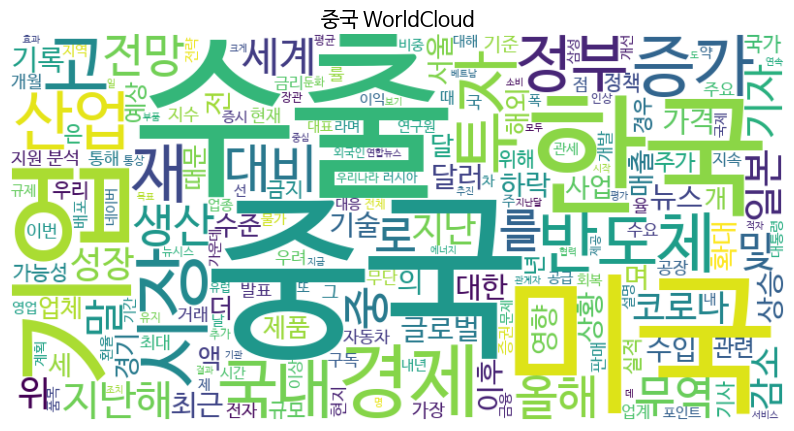

In [44]:
BOW_CN_sum = pd.DataFrame(BOW_CN.sum()).T
# WordCloud 객체 생성
wordcloud = WordCloud(font_path = fontpath, width=800, height=400, background_color='white')

# 단어와 빈도수를 딕셔너리 형태로 변환
word_freq = BOW_CN_sum.to_dict(orient='records')[0]

# WordCloud 생성
wordcloud.generate_from_frequencies(word_freq)

# WordCloud 그리기
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('중국 WorldCloud', fontsize = 15)
plt.savefig('./bow/중국 wordlcloud.png', dpi=300)
plt.show()

#### '미국-수출'키워드 기사 Bag Of Words

In [45]:
BOW_US = pd.read_csv("../DATA/bow/BOW_US.csv", encoding = 'utf-8-sig')
olumns_to_drop = ['ym','것','등','이','수']
BOW_US = BOW_US.drop(olumns_to_drop, axis=1)
BOW_US

,미국,수출,기사,시장,재,투자,한국,경제,뉴스,중국,...,길복순,고갯길,지궁,비티엠,버튜버용,플룸디,페넌트,퍼즐벤처스,아바킷,쿨탠다드
0,13729,8540,8144,6763,6316,5915,5793,5628,5491,5459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11692,6974,8141,5281,5421,4419,7691,4001,5413,4916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25217,11654,4699,6786,7596,5083,9826,6922,4500,9943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12459,8243,3522,5314,4778,4149,5993,4753,3231,7881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10918,7508,6711,4338,5248,4287,5092,4793,4881,5505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,9436,13201,339,6937,848,4814,5900,5826,847,8492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,10410,13889,384,6996,1116,4455,6317,5931,803,10032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,8265,9554,283,4052,648,4148,4458,2941,661,6721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,8183,7361,242,4017,618,2856,4673,2894,797,5669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### '미국-수출'키워드 기사 World Clooud

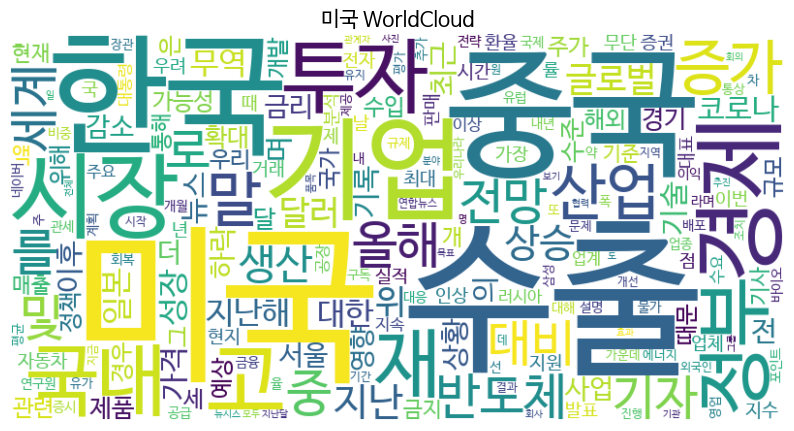

In [46]:
BOW_US_sum = pd.DataFrame(BOW_US.sum()).T
# WordCloud 객체 생성
wordcloud = WordCloud(font_path = fontpath, width=800, height=400, background_color='white')

# 단어와 빈도수를 딕셔너리 형태로 변환
word_freq = BOW_US_sum.to_dict(orient='records')[0]

# WordCloud 생성
wordcloud.generate_from_frequencies(word_freq)

# WordCloud 그리기
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('미국 WorldCloud', fontsize = 15)
plt.savefig('./bow/미국 wordlcloud.png', dpi=300)
plt.show()